<a href="https://colab.research.google.com/github/Rihana24/Multifunctional-NLP-CNN-Comparison-and-Seq-to-Seq-Project/blob/main/SEQ_TO_SEQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEQUENCE TO SEQUENCE WITH ATTENTION MECHANISM

Epoch 01
Train Loss: 1.096 | Acc: 54.27%
Val Loss: 0.507 | Acc: 80.75%
Epoch 02
Train Loss: 0.321 | Acc: 89.85%
Val Loss: 0.279 | Acc: 89.99%
Epoch 03
Train Loss: 0.205 | Acc: 94.32%
Val Loss: 0.170 | Acc: 95.04%
Epoch 04
Train Loss: 0.179 | Acc: 95.20%
Val Loss: 0.112 | Acc: 97.11%
Epoch 05
Train Loss: 0.140 | Acc: 96.36%
Val Loss: 0.100 | Acc: 97.55%
Epoch 06
Train Loss: 0.148 | Acc: 96.04%
Val Loss: 0.160 | Acc: 95.83%
Epoch 07
Train Loss: 0.120 | Acc: 96.89%
Val Loss: 0.115 | Acc: 97.11%
Epoch 08
Train Loss: 0.102 | Acc: 97.38%
Val Loss: 0.084 | Acc: 97.83%
Epoch 09
Train Loss: 0.122 | Acc: 96.82%
Val Loss: 0.121 | Acc: 96.82%
Epoch 10
Train Loss: 0.089 | Acc: 97.82%
Val Loss: 0.142 | Acc: 96.13%


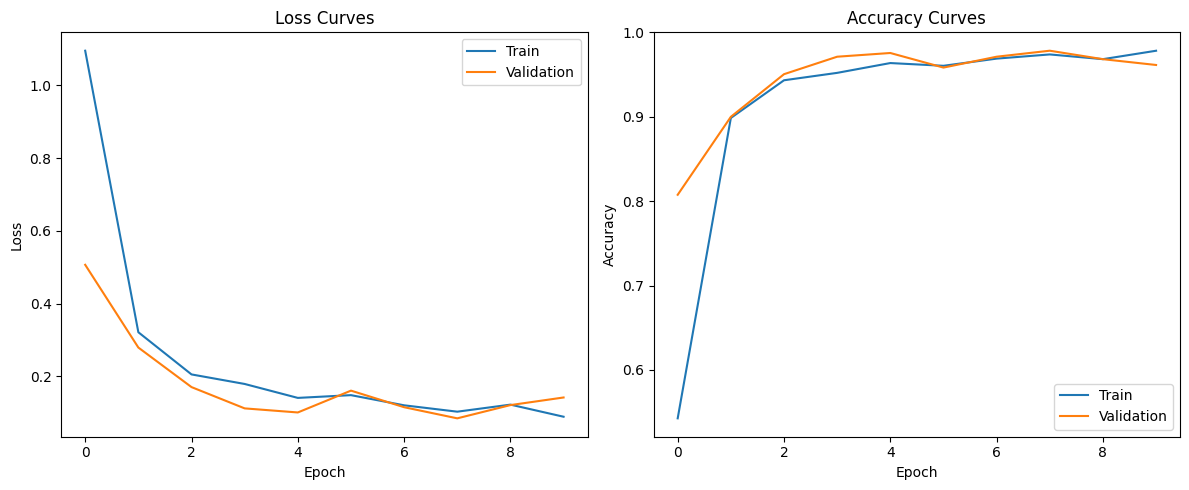

Iteration 1:
  Input: [1, 2, 3, 4, 5]
  Predicted: [0, 5, 4, 5, 5]
Iteration 2:
  Input: [0, 5, 4, 5, 5]
  Predicted: [0, 5, 5, 5, 5, 4, 4]
Iteration 3:
  Input: [0, 5, 5, 5, 5, 4, 4]
  Predicted: [0, 5, 5, 5, 5, 5, 5, 4, 4]
Iteration 4:
  Input: [0, 5, 5, 5, 5, 5, 5, 4, 4]
  Predicted: [0, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4]
Iteration 5:
  Input: [0, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4]
  Predicted: [0, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 11, 11]
Iteration 6:
  Input: [0, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 11, 11]
  Predicted: [0, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 11, 11, 11, 11]
Iteration 7:
  Input: [0, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 11, 11, 11, 11]
  Predicted: [0, 5, 5, 5, 5, 5, 4, 4, 4, 3, 7, 11, 11, 11, 11, 11, 11]
Iteration 8:
  Input: [0, 5, 5, 5, 5, 5, 4, 4, 4, 3, 7, 11, 11, 11, 11, 11, 11]
  Predicted: [0, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 11, 11, 11, 11, 11, 11, 11, 11]
Iteration 9:
  Input: [0, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 11, 11, 11, 11, 11, 11, 11, 11]
  Predicted: [0, 5, 5, 5, 5, 5, 5, 5, 5, 4, 11, 11

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

# Configuration
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PAD_TOKEN = 0
SOS_TOKEN = 10
EOS_TOKEN = 11
vocab_size = 12
embed_dim = 128
hidden_dim = 256
batch_size = 64
num_epochs = 10
teacher_forcing_ratio = 0.5

# 1. Dataset Generation
class ReverseDataset(Dataset):
    def __init__(self, num_samples=10000, min_len=5, max_len=10):
        self.data = [self.generate_sequence(min_len, max_len) for _ in range(num_samples)]

    @staticmethod
    def generate_sequence(min_len=5, max_len=10):
        length = np.random.randint(min_len, max_len+1)
        seq = np.random.randint(0, 9, size=(length,)).tolist()
        return seq, [SOS_TOKEN] + seq[::-1] + [EOS_TOKEN]

    def __getitem__(self, idx):
        src, trg = self.data[idx]
        return torch.LongTensor(src), torch.LongTensor(trg)

    def __len__(self):
        return len(self.data)

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=PAD_TOKEN, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_TOKEN, batch_first=True)
    return src_batch, trg_batch

# 2. Model Implementation
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_TOKEN)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, decoder_hidden, encoder_outputs):
        energy = torch.tanh(self.W(decoder_hidden + encoder_outputs))
        attention = self.V(energy).squeeze(-1)
        return torch.softmax(attention, dim=-1)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_TOKEN)
        self.gru = nn.GRU(embed_dim + hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.attention = Attention()

    def forward(self, x, hidden, encoder_outputs):
        x = self.embedding(x.unsqueeze(1))
        attn_weights = self.attention(hidden.permute(1,0,2), encoder_outputs)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        rnn_input = torch.cat([x, context], dim=-1)
        output, hidden = self.gru(rnn_input, hidden)
        output = self.fc(output.squeeze(1))
        return output, hidden, attn_weights

class Seq2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, src, trg):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        outputs = torch.zeros(trg_len, batch_size, vocab_size).to(device)

        encoder_outputs, hidden = self.encoder(src)
        decoder_input = trg[:, 0]

        for t in range(1, trg_len):
            decoder_output, hidden, _ = self.decoder(decoder_input, hidden, encoder_outputs)
            outputs[t] = decoder_output
            teacher_force = np.random.random() < teacher_forcing_ratio
            decoder_input = trg[:, t] if teacher_force else decoder_output.argmax(-1)

        return outputs.permute(1, 0, 2)

# 3. Training Setup
dataset = ReverseDataset()
train_size = int(0.8 * len(dataset))
train_set, val_set = random_split(dataset, [train_size, len(dataset)-train_size])

train_loader = DataLoader(train_set, batch_size, True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size, False, collate_fn=collate_fn)

model = Seq2Seq().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

# Training/Validation functions
def calculate_accuracy(preds, targets):
    mask = (targets != PAD_TOKEN) & (targets != EOS_TOKEN)
    correct = (preds.argmax(-1) == targets)[mask].sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0

def run_epoch(loader, is_training=True):
    model.train(is_training)
    total_loss = 0
    total_acc = 0

    for src, trg in loader:
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg)
        loss = criterion(output[:, 1:].reshape(-1, vocab_size), trg[:, 1:].reshape(-1))

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        total_acc += calculate_accuracy(output[:, 1:], trg[:, 1:])

    return total_loss / len(loader), total_acc / len(loader)

# 4-5. Training and Visualization
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = run_epoch(train_loader)
    val_loss, val_acc = run_epoch(val_loader, False)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1:02}')
    print(f'Train Loss: {train_loss:.3f} | Acc: {train_acc*100:.2f}%')
    print(f'Val Loss: {val_loss:.3f} | Acc: {val_acc*100:.2f}%')

# Generate a Reversed Sequence

def generate_reversed_sequence(model, initial_sequence, max_iterations=10):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        input_seq = torch.LongTensor(initial_sequence).unsqueeze(0).to(device) # (1, seq_len) add batch dimension

        for i in range(max_iterations):
            # 1. Generate Output
            output = model(input_seq, torch.zeros_like(input_seq))  # (1, seq_len, vocab_size) , feeding zero target because we only want to use the input

            # 2. Get Predicted Sequence
            predicted_sequence = torch.argmax(output, dim=-1).squeeze().cpu().numpy().tolist()  # Remove batch dimension and convert to list

            # 3. Reverse the Predicted Sequence to use as new input for the next iteration
            reversed_sequence = [SOS_TOKEN] + predicted_sequence[::-1] + [EOS_TOKEN]

            input_seq = torch.LongTensor(reversed_sequence).unsqueeze(0).to(device)

            print(f"Iteration {i+1}:")
            print(f"  Input: {initial_sequence}")
            print(f"  Predicted: {predicted_sequence}")

            if initial_sequence == predicted_sequence:
                print("Converged")
                break

            initial_sequence = predicted_sequence


    return initial_sequence

# Train model for required number of epochs
# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Example Usage
trained_model = model
example_sequence = [1, 2, 3, 4, 5]  # Starting with a short sequence
generated_reversed_sequence = generate_reversed_sequence(trained_model, example_sequence)

print("\nFinal Generated Sequence:", generated_reversed_sequence)
